In [110]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import regex as re
import json
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx 
from collections import Counter
from Functions import DataCollection, DataCleaning, GetConnectedMoviesArtist
import numpy as np

In [111]:
with open('connected_movies_and_casts.json', 'r') as file:
    connected_movies = json.load(file)

In [112]:
df_movies = pd.read_json('df_movies.json', orient='table')

In [113]:
df_movies.shape

(5780, 7)

# Network Creation

In [116]:
# Create undirected Graph
G_movies = nx.Graph()

# Adding nodes
movies_nodes = list(connected_movies.keys())
G_movies.add_nodes_from(movies_nodes)

node_attr = df_movies[['Title','Director','Cast','Country','Genre', 
                'Year']].set_index('Title').to_dict('index') # Creating a dictionary with the characters and their attributes

nx.set_node_attributes(G_movies, node_attr) #Adding attributes to the graph

for movie in connected_movies.keys():
    for connected_movie in connected_movies[movie]: 
        weight = len(connected_movies[movie][connected_movie])
        attribute_value = connected_movies[movie][connected_movie]
        G_movies.add_edges_from([(movie, connected_movie)], weight=weight, attribute_name=attribute_value)

In [117]:
print(G_movies.edges["365 Days: This Day", "365 Days"])

{'weight': 3, 'attribute_name': ['michele morrone', 'anna-maria sieklucka', 'magdalena lamparska']}


In [118]:
print(G_movies.nodes["365 Days: This Day"])

{'Director': 'barbara biaowas,tomasz mandes', 'Cast': 'anna-maria sieklucka,michele morrone, rebecca casiraghi,magdalena lamparska', 'Country': 'europe', 'Genre': 'Thriller', 'Year': '2022'}


# Network Analysis

In [119]:
print("The network consist of: ", G_movies.number_of_nodes(), " nodes (Movies)")
print("The network consist of: ", G_movies.number_of_edges(), " edges")

The network consist of:  5780  nodes (Movies)
The network consist of:  37253  edges


# Largest Connected Component

In [120]:
#Extracting the largest component
connected_components = nx.connected_components(G_movies)
# Finding the largest connected component
largest_cc = max(connected_components, key=len)
# Creating a subgraph for the largest connected component
G_largest_cc = G_movies.subgraph(largest_cc).copy()

In [121]:
print("The largest connected component network consist of: ", G_largest_cc.number_of_nodes(), " nodes (Movies)")
print("The largest connected component network consist of: ", G_largest_cc.number_of_edges(), " edges")

The largest connected component network consist of:  4422  nodes (Movies)
The largest connected component network consist of:  36958  edges


## Density (average degree)

In [122]:
print("The average degree of the GCC is:", round(sum(dict(G_largest_cc.degree()).values())/len(G_largest_cc.degree)))

The average degree of the GCC is: 17


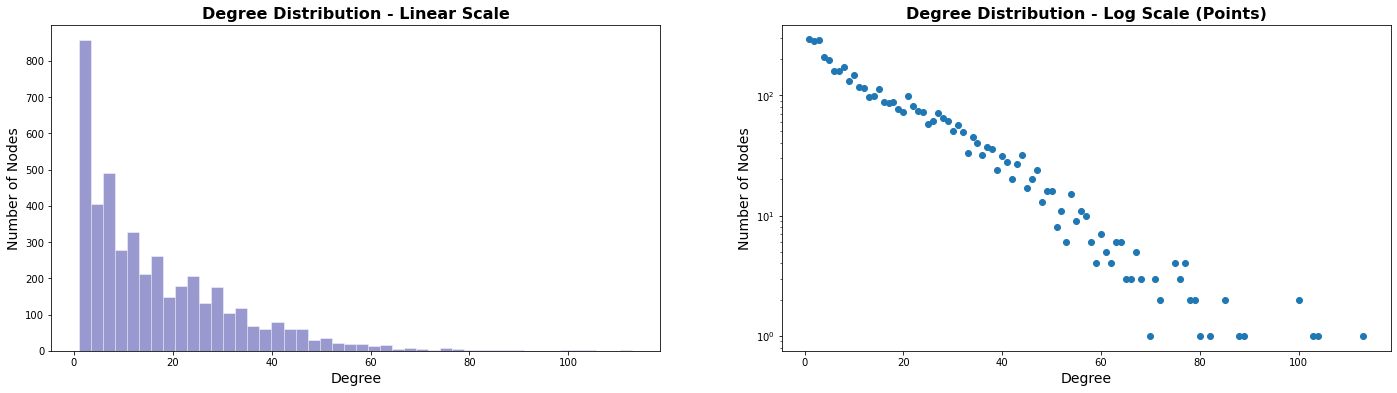

In [123]:
# Calculating degrees for each node
degrees = [G_largest_cc.degree(n) for n in G_largest_cc.nodes()]

# Convert the degrees list to a DataFrame
degrees_df = pd.DataFrame(degrees, columns=['Degree'])

# Set up the matplotlib figure
plt.figure(figsize=(24, 6))

# First subplot for the regular scale histogram
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.distplot(degrees_df['Degree'], kde=False, color='darkblue', hist_kws={'edgecolor':'white'})
plt.title('Degree Distribution - Linear Scale', fontweight="bold", fontsize=16)
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Number of Nodes', fontsize=14)

# Second subplot for the logarithmic scale histogram
plt.subplot(1, 2, 2)
plt.scatter(degree_counts['Degree'], degree_counts['Count'])
plt.title('Degree Distribution - Log Scale (Points)', fontweight="bold", fontsize=16)
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Number of Nodes', fontsize=14)
plt.yscale('log')

# Show the plot
plt.show()


## Degree distribution

In [124]:
df_movies['Genre'].value_counts()

Horror             1860
Comedy             1051
Action              874
Science Fiction     579
Adventure           501
Thriller            453
Fantasy             373
Mix                  89
Name: Genre, dtype: int64

In [125]:
# Saving nodes in lists according to their genre
n_horror = [x for x,y in G_largest_cc.nodes(data=True) if y['Genre']=='Horror']
n_comedy = [x for x,y in G_largest_cc.nodes(data=True) if y['Genre']=='Comedy']
n_action = [x for x,y in G_largest_cc.nodes(data=True) if y['Genre']=='Action']
n_scify = [x for x,y in G_largest_cc.nodes(data=True) if y['Genre']=='Science Fiction']
n_adventure = [x for x,y in G_largest_cc.nodes(data=True) if y['Genre']=='Adventure']
n_thriller = [x for x,y in G_largest_cc.nodes(data=True) if y['Genre']=='Thriller']
n_fantasy = [x for x,y in G_largest_cc.nodes(data=True) if y['Genre']=='Fantasy']
n_mix = [x for x,y in G_largest_cc.nodes(data=True) if y['Genre']=='Mix']

In [127]:
#Degree distribution:
deg_horror = np.array(list(dict(G_largest_cc.degree(n_horror)).values()))
deg_comedy = np.array(list(dict(G_largest_cc.degree(n_comedy)).values()))
deg_action = np.array(list(dict(G_largest_cc.degree(n_action)).values()))
deg_scify = np.array(list(dict(G_largest_cc.degree(n_scify)).values()))
deg_adventure = np.array(list(dict(G_largest_cc.degree(n_adventure)).values()))
deg_thriller = np.array(list(dict(G_largest_cc.degree(n_thriller)).values()))
deg_fantasy = np.array(list(dict(G_largest_cc.degree(n_fantasy)).values()))
deg_mix = np.array(list(dict(G_largest_cc.degree(n_mix)).values()))

#Finding the unique values and how many time they appear 
values_horror, counts_horror = np.unique(deg_horror, return_counts=True)
values_comedy, counts_comedy = np.unique(deg_comedy, return_counts=True)
values_action, counts_action = np.unique(deg_action, return_counts=True)
values_scify, counts_scify = np.unique(deg_scify, return_counts=True)
values_adventure, counts_adventure = np.unique(deg_adventure, return_counts=True)
values_thriller, counts_thriller = np.unique(deg_thriller, return_counts=True)
values_fantasy, counts_fantasy = np.unique(deg_fantasy, return_counts=True)
values_mix, counts_mix = np.unique(deg_mix, return_counts=True)

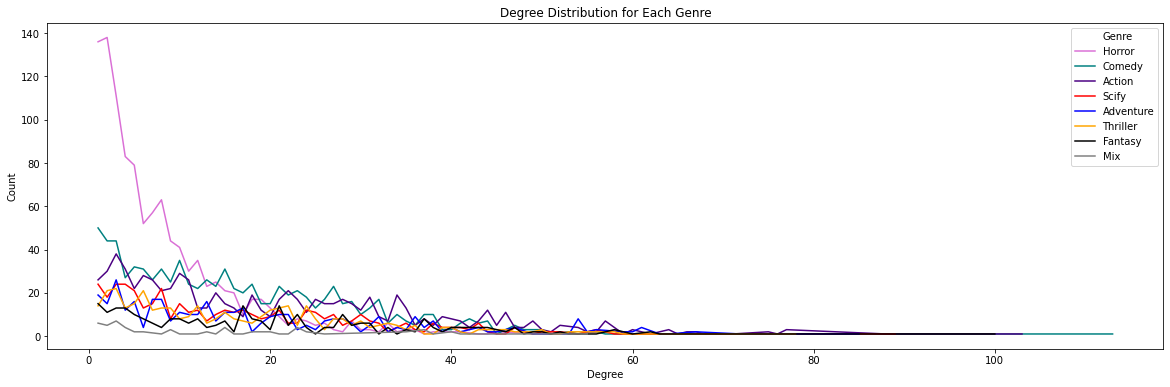

In [131]:
# Sample data for each genre - replace these with your actual data
horror_data = pd.DataFrame({'Degree': values_horror, 'Count': counts_horror, 'Genre': 'Horror'})
comedy_data = pd.DataFrame({'Degree': values_comedy, 'Count': counts_comedy, 'Genre': 'Comedy'})
action_data = pd.DataFrame({'Degree': values_action, 'Count': counts_action, 'Genre': 'Action'})
scify_data = pd.DataFrame({'Degree': values_scify, 'Count': counts_scify, 'Genre': 'Scify'})
adventure_data = pd.DataFrame({'Degree': values_adventure, 'Count': counts_adventure, 'Genre': 'Adventure'})
thriller_data = pd.DataFrame({'Degree': values_thriller, 'Count': counts_thriller, 'Genre': 'Thriller'})
fantasy_data = pd.DataFrame({'Degree': values_fantasy, 'Count': counts_fantasy, 'Genre': 'Fantasy'})
mix_data = pd.DataFrame({'Degree': values_mix, 'Count': counts_mix, 'Genre': 'Mix'})

# Concatenate all DataFrames
all_genres_data = pd.concat([horror_data, comedy_data, action_data, scify_data, adventure_data, thriller_data, fantasy_data, mix_data])

# Create the plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=all_genres_data, x='Degree', y='Count', hue='Genre', 
             palette=['#DA70D6', '#008080', '#4B0082', 'red', 'blue', 'orange', 'black', 'grey'])  # Adjust the palette as needed
plt.title("Degree Distribution for Each Genre")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()


### Most connected movies

In [153]:
degrees = dict(G_largest_cc.degree())
degrees_movies = {node: degree for node, degree in degrees.items()}
top_connected = sorted(degrees_movies, key=degrees_movies.get, reverse=True)[:10]
print("Top 10 connected movies: ", top_connected)

Top 10 connected movies:  ['Amsterdam', "Don't Look Up", 'Thor: Love and Thunder', 'Avengers: Endgame', 'Dolittle', "Zack Snyder's Justice League", 'F9', 'The Avengers', 'Thor: Ragnarok', 'The Croods: A New Age']


In [152]:
G_largest_cc.nodes['Amsterdam']

{'Director': 'david o russell',
 'Cast': 'christian bale,margot robbie,john david washington,chris rock,anya taylor-joy,zoe saldana,mike myers,michael shannon,timothy olyphant,andrea riseborough,taylor swift,matthias schoenaerts,alessandro nivola,rami malek,robert de niro',
 'Country': 'united states',
 'Genre': 'Comedy',
 'Year': '2022'}

In [169]:
for movie in top_connected:
    attributes = G_largest_cc.nodes[movie]
    directors = attributes['Director']
    #casts = attributes['Cast']
    
    print(f"Movie: {movie}")
    print(f"Directors: {directors}")
   # print(f"Casts: {casts}")
    print(f"Degree: {degrees[movie]}\n")

Movie: Amsterdam
Directors: david o russell
Degree: 113

Movie: Don't Look Up
Directors: adam mc kay
Degree: 104

Movie: Thor: Love and Thunder
Directors: taika waititi
Degree: 103

Movie: Avengers: Endgame
Directors: anthony and joseph russo
Degree: 100

Movie: Dolittle
Directors: stephen gaghan
Degree: 100

Movie: Zack Snyder's Justice League
Directors: zack snyder
Degree: 89

Movie: F9
Directors: justin lin
Degree: 88

Movie: The Avengers
Directors: joss whedon
Degree: 85

Movie: Thor: Ragnarok
Directors: taika waititi
Degree: 85

Movie: The Croods: A New Age
Directors: joel crawford
Degree: 82



In [167]:
# Create a dictionary to store cast members and their counts for each top_connected_movie
movie_cast_count = {}

# Iterate through the movies and their cast lists
for top_connected_movie in top_connected:
    for movie, cast_list in connected_movies[top_connected_movie].items():
        if top_connected_movie not in movie_cast_count:
            movie_cast_count[top_connected_movie] = {}
        for cast_member in cast_list:
            if cast_member in movie_cast_count[top_connected_movie]:
                movie_cast_count[top_connected_movie][cast_member]["Count"] += 1
            else:
                movie_cast_count[top_connected_movie][cast_member] = {"Count": 1}

# Print the cast members, their counts, and associated movies for each top_connected_movie
for movie, cast_data in movie_cast_count.items():
    print(f"Top Connected Movie: {movie}")
    for cast_member, data in cast_data.items():
        count = data["Count"]
        print(f"  Cast Member: {cast_member}, Count: {count}")
    print()


Top Connected Movie: Amsterdam
  Cast Member: rami malek, Count: 3
  Cast Member: christian bale, Count: 16
  Cast Member: michael shannon, Count: 9
  Cast Member: matthias schoenaerts, Count: 2
  Cast Member: anya taylor-joy, Count: 8
  Cast Member: timothy olyphant, Count: 11
  Cast Member: robert de niro, Count: 17
  Cast Member: margot robbie, Count: 7
  Cast Member: zoe saldana, Count: 14
  Cast Member: andrea riseborough, Count: 5
  Cast Member: chris rock, Count: 9
  Cast Member: mike myers, Count: 7
  Cast Member: taylor swift, Count: 2
  Cast Member: john david washington, Count: 2
  Cast Member: alessandro nivola, Count: 1

Top Connected Movie: Don't Look Up
  Cast Member: tyler perry, Count: 5
  Cast Member: ron perlman, Count: 14
  Cast Member: cate blanchett, Count: 14
  Cast Member: chris evans, Count: 18
  Cast Member: leonardo di caprio, Count: 6
  Cast Member: tomer sisley, Count: 2
  Cast Member: jennifer lawrence, Count: 12
  Cast Member: meryl streep, Count: 8
  Cas

### Most connected movies for each genre

In [141]:
most_connected_per_genre = {}

# Iterate through unique genres in the graph
unique_genres = set(nx.get_node_attributes(G_largest_cc, 'Genre').values())
for genre in unique_genres:
    # Create a subgraph containing only nodes with the current genre
    subgraph = G_largest_cc.subgraph([node for node, attributes in G_largest_cc.nodes(data=True) if attributes['Genre'] == genre])
    
    # Calculate the degree for each node in the subgraph
    degrees = dict(subgraph.degree())
    
    # Find the movie with the highest degree in the subgraph
    top_connected = max(degrees, key=degrees.get)
    
    # Store the result in the most_connected_per_genre dictionary
    most_connected_per_genre[genre] = top_connected

# Print the most connected movie for each genre
for genre, movie in most_connected_per_genre.items():
    print(f"Most connected movie in the '{genre}' genre: {movie} (Degree: {G_largest_cc.degree(movie)})")


Most connected movie in the 'Thriller' genre: Eastern Promises (Degree: 30)
Most connected movie in the 'Science Fiction' genre: Captain America: Civil War (Degree: 40)
Most connected movie in the 'Mix' genre: Ghost Rider (Degree: 40)
Most connected movie in the 'Comedy' genre: Zoolander (Degree: 56)
Most connected movie in the 'Adventure' genre: Reign of Fire (Degree: 54)
Most connected movie in the 'Action' genre: Triple Threat (Degree: 65)
Most connected movie in the 'Horror' genre: Chillerama (Degree: 38)
Most connected movie in the 'Fantasy' genre: Beauty and the Beast bill condon (Degree: 80)


### Most connected movies over time for each genre

In [147]:
decades = [(2000, 2005), (2005, 2010), (2010, 2015), (2015,2023)]

# Create a dictionary to store the most connected movie for each genre and decade
most_connected_per_genre_and_decade = {}

# Iterate through unique genres in the graph
unique_genres = set(nx.get_node_attributes(G_largest_cc, 'Genre').values())
for genre in unique_genres:
    for decade in decades:
        year_start, year_end = map(int, decade)
        # Create a subgraph containing only nodes with the current genre and within the current decade
        subgraph = G_largest_cc.subgraph([node for node, attributes in G_largest_cc.nodes(data=True) if
                              attributes['Genre'] == genre and decade[0] <= int(attributes['Year']) < decade[1]])
        
        # Calculate the degree for each node in the subgraph
        degrees = dict(subgraph.degree())
        
        if degrees:
            # Find the movie with the highest degree in the subgraph
            top_connected = max(degrees, key=degrees.get)
            
            # Store the result in the most_connected_per_genre_and_decade dictionary
            most_connected_per_genre_and_decade[(genre, decade)] = top_connected

# Print the most connected movie for each genre and decade
for (genre, decade), movie in most_connected_per_genre_and_decade.items():
    print(f"Most connected movie in the '{genre}' genre in the decade {decade[0]}-{decade[1]}: {movie} (Degree: {G_largest_cc.degree(movie)})")


Most connected movie in the 'Thriller' genre in the decade 2000-2005: Basic (Degree: 53)
Most connected movie in the 'Thriller' genre in the decade 2005-2010: The International (Degree: 24)
Most connected movie in the 'Thriller' genre in the decade 2010-2015: The Next Three Days (Degree: 44)
Most connected movie in the 'Thriller' genre in the decade 2015-2023: Cold Pursuit (Degree: 28)
Most connected movie in the 'Science Fiction' genre in the decade 2000-2005: Mission to Mars (Degree: 15)
Most connected movie in the 'Science Fiction' genre in the decade 2005-2010: Sunshine (Degree: 35)
Most connected movie in the 'Science Fiction' genre in the decade 2010-2015: This Is the End (Degree: 48)
Most connected movie in the 'Science Fiction' genre in the decade 2015-2023: Deadpool (Degree: 44)
Most connected movie in the 'Mix' genre in the decade 2000-2005: Vanilla Sky (Degree: 37)
Most connected movie in the 'Mix' genre in the decade 2005-2010: Children of Men (Degree: 42)
Most connected mo

Overvej: 

- Backbone 
- betweenness uge 5
- Centrality uge 5


to do: 
- community detecton
- plot 
- 